<a href="https://colab.research.google.com/github/SunbalAzizLCWU/BSSE-DS-Project/blob/main/SunbalW1To8Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# =======================================================================
#
#   Data Science - AI: Mid-Term Project Notebook (Weeks 1-8)
#   Student: Sunbal Aziz (2225165139)
#   Project: Image-based Waste Classification
#
# =======================================================================

# -----------------------------------------------------------------------
# Section 1: Initial Setup and Core Libraries
# -----------------------------------------------------------------------
print("--- Section 1: Initializing ---")

# --- Install Kaggle Library ---
# This is necessary to download the dataset from the Kaggle platform.
!pip install kaggle

# --- Import Core Libraries ---
# These are the main libraries we will use throughout the project.
import os                     # For navigating file paths
import numpy as np            # For numerical operations and handling arrays
import pandas as pd           # For managing data in tables (DataFrames)
import matplotlib.pyplot as plt # For creating plots
import seaborn as sns         # For creating more advanced, beautiful plots
from PIL import Image         # For opening, resizing, and processing images
import warnings               # To hide unnecessary warnings for a clean report

# --- Import Scikit-Learn (sklearn) Modules ---
# These are the machine learning tools we will use.

# Preprocessing
from sklearn.model_selection import train_test_split # To split data
from sklearn.preprocessing import StandardScaler, label_binarize # To scale data and help with ROC curves

# Models
from sklearn.linear_model import LogisticRegression    # W5: Baseline Model
from sklearn.tree import DecisionTreeClassifier      # W6: Model 1
from sklearn.ensemble import RandomForestClassifier  # W6: Best Model
from sklearn.cluster import KMeans                   # W8: Clustering Model
from sklearn.decomposition import PCA                # W8: Dimensionality Reduction

# Evaluation
from sklearn.metrics import (
    classification_report,  # W7: Precision, Recall, F1
    confusion_matrix,       # W7: Confusion Matrix
    RocCurveDisplay,        # W7: ROC Curve
    accuracy_score          # W6: Simple Accuracy
)

# --- Global Settings ---
# Set a consistent style for all our plots
sns.set_style("whitegrid")
# Suppress minor warnings to keep the output clean
warnings.filterwarnings('ignore')

print("All libraries imported successfully.")


--- Section 1: Initializing ---
All libraries imported successfully.


In [11]:

# -----------------------------------------------------------------------
# Section 2: Week 1 Task (Iris Dataset)
# -----------------------------------------------------------------------
print("\n--- Section 2: Re-running Week 1 Task ---")
# This task was to load a sample dataset (Iris) to confirm setup.
try:
    iris_url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv'
    df_iris = pd.read_csv(iris_url)
    print("Displaying the first 10 rows of the Iris dataset:")
    print(df_iris.head(10))
except Exception as e:
    print(f"Could not load Iris dataset: {e}")


--- Section 2: Re-running Week 1 Task ---
Displaying the first 10 rows of the Iris dataset:
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
5           5.4          3.9           1.7          0.4  setosa
6           4.6          3.4           1.4          0.3  setosa
7           5.0          3.4           1.5          0.2  setosa
8           4.4          2.9           1.4          0.2  setosa
9           4.9          3.1           1.5          0.1  setosa


In [12]:
# -----------------------------------------------------------------------
# Section 3: Project Data Setup (from Week 2)
# -----------------------------------------------------------------------
print("\n--- Section 3: Setting up Project Dataset (Week 2) ---")

# 1. Set up the Kaggle API token
# (Ensure kaggle.json is uploaded to your Colab environment)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API token installed.")

# 2. Download the dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification
print("\nDataset downloaded. Unzipping...")

# 3. Clean old directories and unzip
# We remove the old folder to prevent path errors from multiple runs
!rm -rf "Garbage classification"
!unzip -q garbage-classification.zip
print("Dataset unzipped and ready.")

# --- Define Global Constants for the Project ---
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
IMG_SIZE = 64 # We will resize all images to 64x64 for the classical models

# --- Dynamic Path Resolution (THE FIX) ---
# This will fix path errors by finding the correct directory
path_option_1 = 'Garbage classification'
path_option_2 = 'Garbage classification/Garbage classification'
DATA_DIR = ''

# Check which path contains the class folders
if os.path.isdir(os.path.join(path_option_2, 'cardboard')):
    DATA_DIR = path_option_2
elif os.path.isdir(os.path.join(path_option_1, 'cardboard')):
    DATA_DIR = path_option_1
else:
    print("CRITICAL ERROR: Could not find data directories. Please check unzip contents.")
    # We default to one, but it will likely fail in the next steps
    DATA_DIR = 'Garbage classification/Garbage classification'

print(f"Data directory successfully set to: {DATA_DIR}")


--- Section 3: Setting up Project Dataset (Week 2) ---
Kaggle API token installed.
Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.51GB/s]

Dataset downloaded. Unzipping...
Dataset unzipped and ready.
Data directory successfully set to: Garbage classification/Garbage classification


In [13]:
# -----------------------------------------------------------------------
# Section 4: Data Cleaning & Verification (from Week 2)
# -----------------------------------------------------------------------
print("\n--- Section 4: Verifying Image Data (Week 2) ---")

# This script iterates through all files to check for corruption
# This was our adaptation of "handling missing values"
total_files_found = 0
total_files_verified = 0
corrupted_files = 0
class_counts = {}

for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_dir):
        print(f"Warning: Directory not found: {class_dir}")
        continue

    class_file_count = 0
    for image_file in os.listdir(class_dir):
        total_files_found += 1
        image_path = os.path.join(class_dir, image_file)
        try:
            # Try to open the image to check if it's valid
            with Image.open(image_path) as img:
                img.verify() # Verify the image integrity

            # If successful, count it
            class_file_count += 1
            total_files_verified += 1
        except Exception as e:
            # This is a "corrupted" or "missing" value
            print(f"Skipping corrupted file: {image_path} | Error: {e}")
            corrupted_files += 1
    class_counts[class_name] = class_file_count

print("\n--- Data Cleaning Summary ---")
print(f"Total files found (Before): {total_files_found}")
print(f"Corrupted files removed: {corrupted_files}")
print(f"Total clean files (After): {total_files_verified}")
print("\nFinal Clean Dataset Distribution:")
for class_name, count in class_counts.items():
    print(f"- {class_name.title()}: {count} images")



--- Section 4: Verifying Image Data (Week 2) ---

--- Data Cleaning Summary ---
Total files found (Before): 2527
Corrupted files removed: 0
Total clean files (After): 2527

Final Clean Dataset Distribution:
- Cardboard: 403 images
- Glass: 501 images
- Metal: 410 images
- Paper: 594 images
- Plastic: 482 images
- Trash: 137 images



--- Section 5: Exploratory Data Analysis (Weeks 3 & 4) ---
Scanning image metadata (dimensions, class)...
Scan complete. Found metadata for 2527 valid images.
Generating Plot 1: Class Distribution...


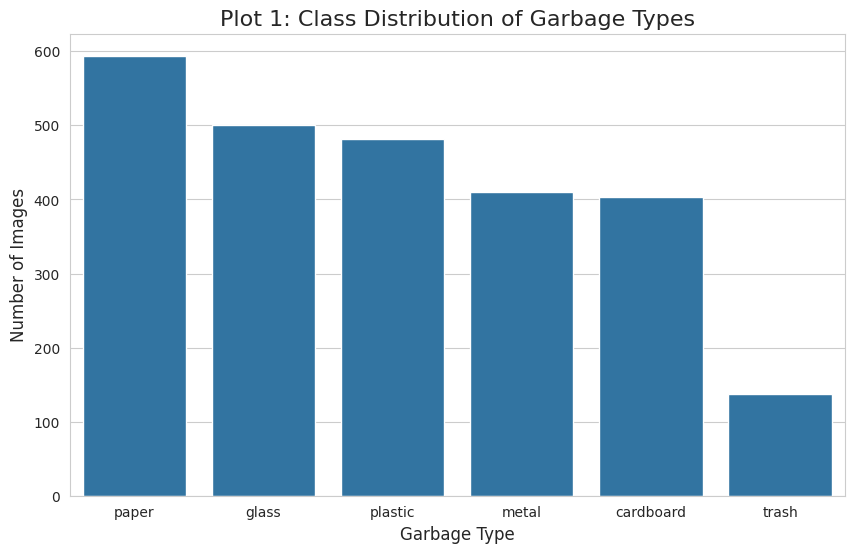

Generating Plot 2: Sample Images from Each Class...


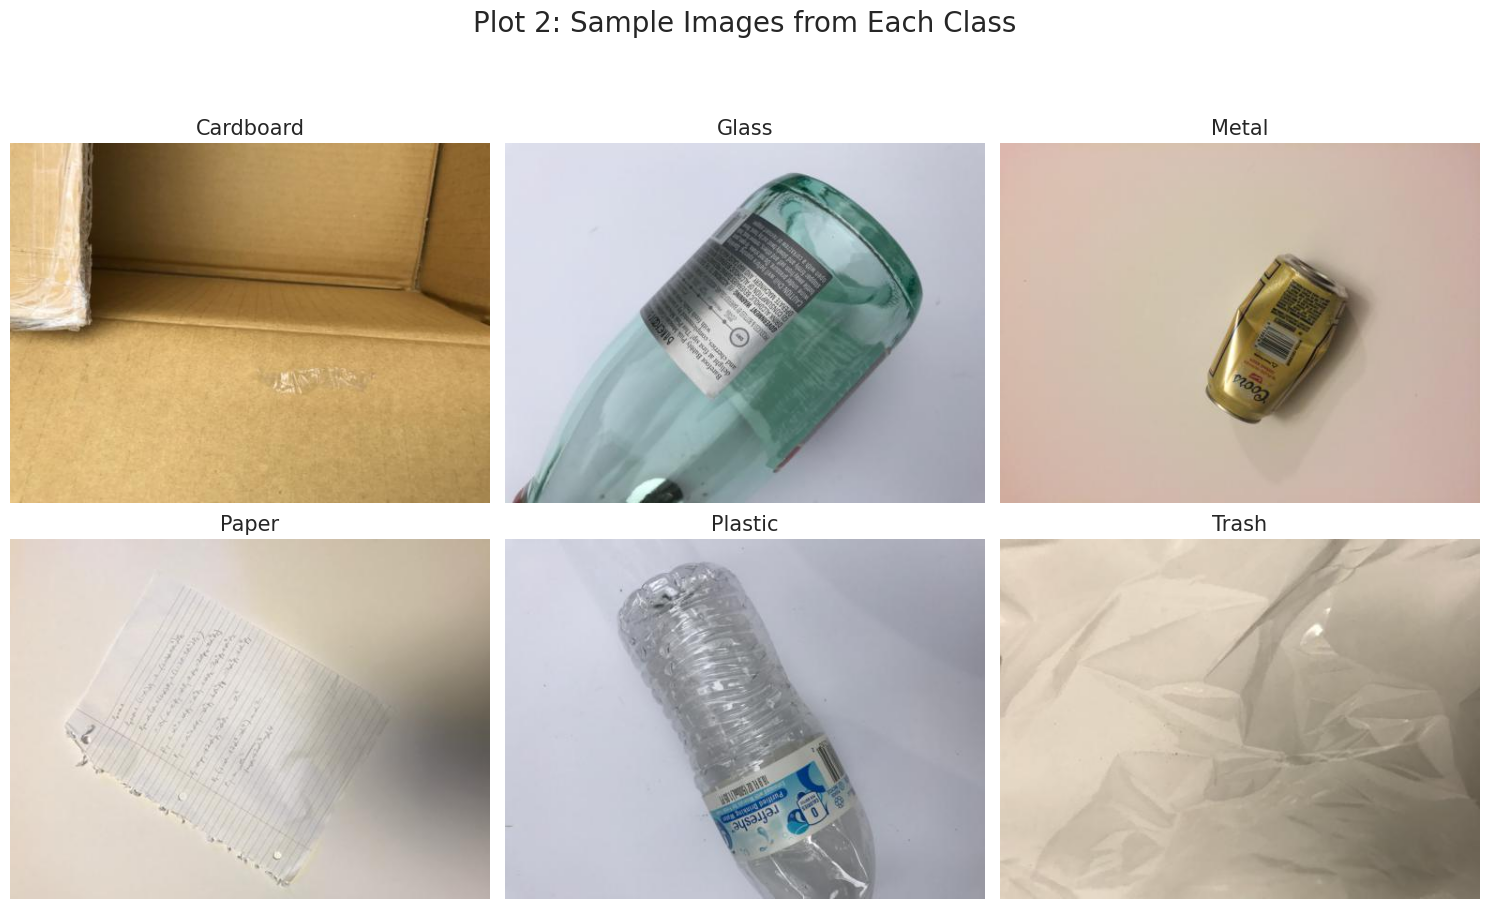


--- Week 4: Statistical Analysis ---
        width  height
count  2527.0  2527.0
mean    512.0   384.0
std       0.0     0.0
min     512.0   384.0
25%     512.0   384.0
50%     512.0   384.0
75%     512.0   384.0
max     512.0   384.0
Generating Plot 3: Metadata Correlation (Box Plots)...


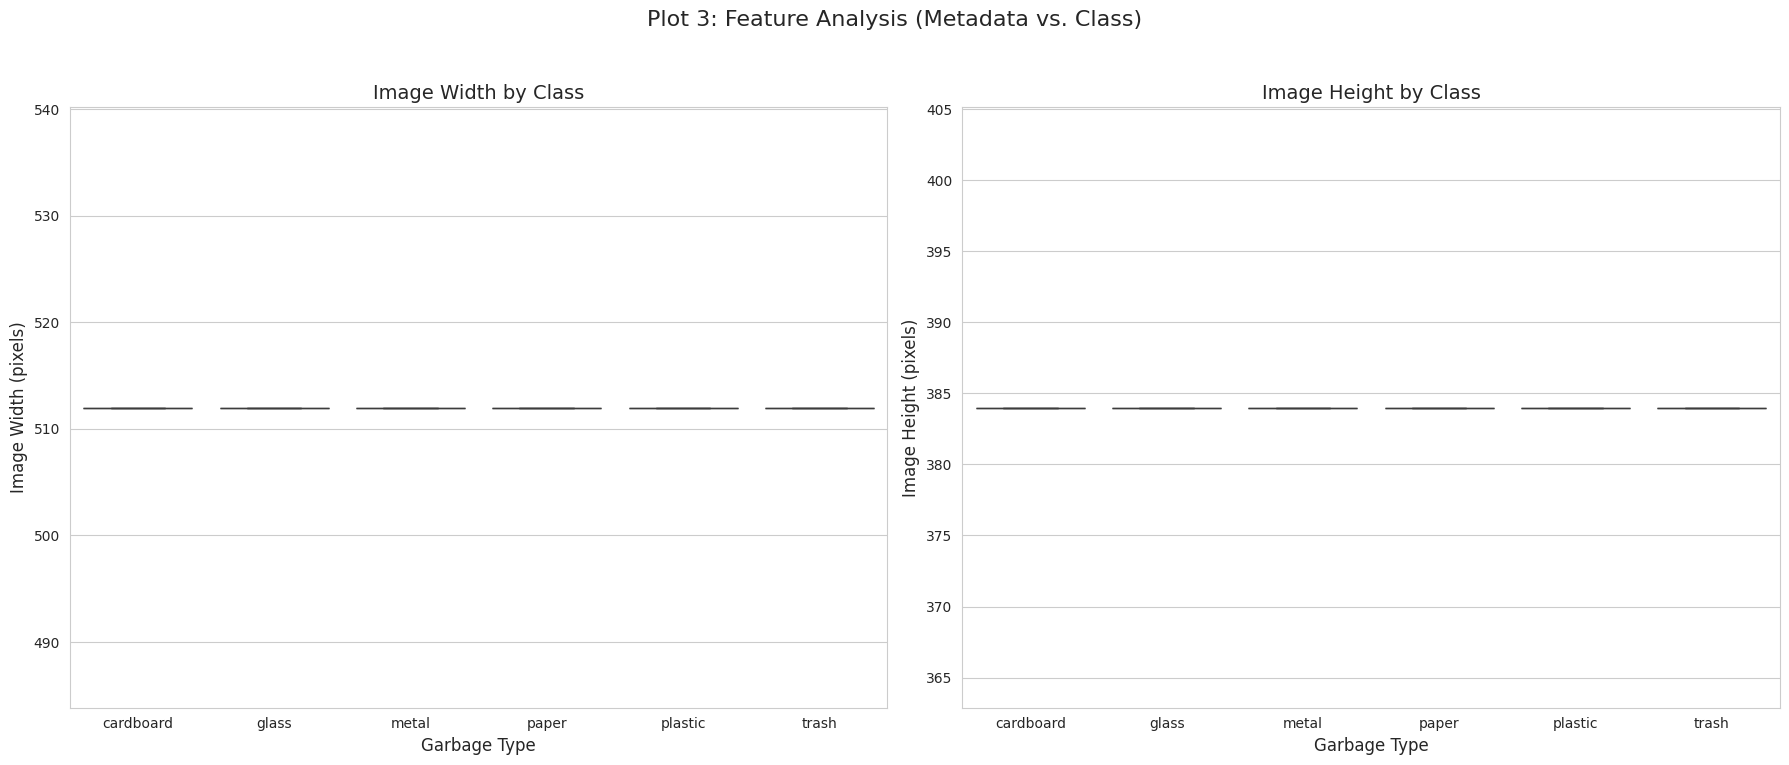

In [14]:
# -----------------------------------------------------------------------
# Section 5: Data Analysis & Visualization (from Weeks 3 & 4)
# -----------------------------------------------------------------------
print("\n--- Section 5: Exploratory Data Analysis (Weeks 3 & 4) ---")

# --- 5.1: Metadata Extraction ---
# We scan all images again, this time to get their metadata (like size)
# for analysis, as done in Week 3.
print("Scanning image metadata (dimensions, class)...")
image_metadata = []
for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_dir): continue

    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                image_metadata.append({
                    'class': class_name,
                    'path': image_path,
                    'width': width,
                    'height': height
                })
        except Exception as e:
            pass # We already reported corrupted files

# Convert the metadata into a DataFrame for easy plotting
df_meta = pd.DataFrame(image_metadata)
print(f"Scan complete. Found metadata for {len(df_meta)} valid images.")

# --- 5.2: Plot 1: Class Distribution (Week 3) ---
print("Generating Plot 1: Class Distribution...")
plt.figure(figsize=(10, 6))
sns.countplot(data=df_meta, x='class', order=df_meta['class'].value_counts().index)
plt.title('Plot 1: Class Distribution of Garbage Types', fontsize=16)
plt.xlabel('Garbage Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()

# --- 5.3: Plot 2: Sample Images (Week 3) ---
print("Generating Plot 2: Sample Images from Each Class...")
plt.figure(figsize=(15, 10))
plt.suptitle('Plot 2: Sample Images from Each Class', fontsize=20)
for i, class_name in enumerate(CLASSES):
    try:
        sample_path = df_meta[df_meta['class'] == class_name].sample(1)['path'].values[0]
        img = Image.open(sample_path)
        plt.subplot(2, 3, i + 1) # Create a 2x3 grid
        plt.imshow(img)
        plt.title(class_name.title(), fontsize=15)
        plt.axis('off')
    except Exception as e:
        plt.subplot(2, 3, i + 1)
        plt.title(f"Could not load image for {class_name}", fontsize=15)
        plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 5.4: Statistical Analysis (Week 4) ---
print("\n--- Week 4: Statistical Analysis ---")
# Use .describe() for mean, median (50%), and std
stats_summary = df_meta.describe()
print(stats_summary)

# --- 5.5: Plot 3: Metadata Correlation (Week 4) ---
print("Generating Plot 3: Metadata Correlation (Box Plots)...")
# We use box plots to see if 'class' (target) is related to 'width' or 'height'.
plt.figure(figsize=(18, 8))
plt.suptitle('Plot 3: Feature Analysis (Metadata vs. Class)', fontsize=16)

# Plot 1: Width vs. Class
plt.subplot(1, 2, 1)
sns.boxplot(data=df_meta, x='class', y='width', palette='muted')
plt.title('Image Width by Class', fontsize=14)
plt.xlabel('Garbage Type', fontsize=12)
plt.ylabel('Image Width (pixels)', fontsize=12)

# Plot 2: Height vs. Class
plt.subplot(1, 2, 2)
sns.boxplot(data=df_meta, x='class', y='height', palette='muted')
plt.title('Image Height by Class', fontsize=14)
plt.xlabel('Garbage Type', fontsize=12)
plt.ylabel('Image Height (pixels)', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [15]:

# -----------------------------------------------------------------------
# Section 6: Data Preprocessing for Machine Learning (from Week 5)
# -----------------------------------------------------------------------
print("\n--- Section 6: Preprocessing for ML (Week 5) ---")
# This is the "flattening" process required for classical models.

# Lists to hold our ML-ready data
X_flat_data = [] # This will hold the flattened image data
y_labels = []    # This will hold the numerical labels

print(f"Loading and flattening all images to {IMG_SIZE}x{IMG_SIZE}...")
for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    class_label = CLASSES.index(class_name) # 'paper' -> 3
    if not os.path.isdir(class_dir):
        print(f"Warning: Skipping missing directory {class_dir}")
        continue

    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        try:
            # Open image, convert to grayscale, and resize
            img = Image.open(image_path).convert('L') # 'L' = grayscale
            img_resized = img.resize((IMG_SIZE, IMG_SIZE))

            # Flatten the 64x64 image into a 1D vector of 4096 pixels
            img_vector = np.array(img_resized).flatten()

            X_flat_data.append(img_vector)
            y_labels.append(class_label)
        except Exception as e:
            pass # We already reported corrupted files

# Convert lists to NumPy arrays
X = np.array(X_flat_data)
y = np.array(y_labels)

print(f"\nOriginal data shape (X): {X.shape}") # (2527, 4096)
print(f"Labels shape (y): {y.shape}")         # (2527,)

# --- 6.2: Scale Data ---
print("Scaling data (StandardScaler)...")
# Scaling is crucial for models like Logistic Regression and ANNs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Data scaling complete.")

# --- 6.3: Train/Test Split ---
print("Splitting data into 80% train and 20% test sets...")
# We do this once so all models are tested on the same data
# We use stratify=y to ensure the class imbalance is in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")



--- Section 6: Preprocessing for ML (Week 5) ---
Loading and flattening all images to 64x64...

Original data shape (X): (2527, 4096)
Labels shape (y): (2527,)
Scaling data (StandardScaler)...
Data scaling complete.
Splitting data into 80% train and 20% test sets...
Training samples: 2021
Testing samples: 506


In [16]:

# -----------------------------------------------------------------------
# Section 7: Classical Model Benchmarking (from Weeks 5 & 6)
# -----------------------------------------------------------------------
print("\n--- Section 7: Training Classical Models (Weeks 5 & 6) ---")

# We will train all three models from W5 and W6 to compare them.
model_accuracies = {}

# --- Model 1: Logistic Regression (Week 5) ---
print("Training Model 1: Logistic Regression...")
model_logreg = LogisticRegression(max_iter=1000, random_state=42)
model_logreg.fit(X_train, y_train)
y_pred_logreg = model_logreg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
model_accuracies['Logistic Regression'] = acc_logreg
print("Logistic Regression training complete.")

# --- Model 2: Decision Tree (Week 6) ---
print("Training Model 2: Decision Tree...")
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
model_accuracies['Decision Tree'] = acc_tree
print("Decision Tree training complete.")

# --- Model 3: Random Forest (Week 6) ---
print("Training Model 3: Random Forest... (This may take a minute)")
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
model_accuracies['Random Forest'] = acc_rf
print("Random Forest training complete.")

# --- 6.4: Final Model Comparison Report ---
print("\n=======================================================")
print("      Week 6 Assignment: Model Comparison Report")
print("=======================================================")
print("Comparing accuracy of all trained models on the test set:\n")
for model_name, accuracy in model_accuracies.items():
    print(f"- {model_name + ':':<25} {accuracy * 100:.2f}%")
print("=======================================================")



--- Section 7: Training Classical Models (Weeks 5 & 6) ---
Training Model 1: Logistic Regression...
Logistic Regression training complete.
Training Model 2: Decision Tree...
Decision Tree training complete.
Training Model 3: Random Forest... (This may take a minute)
Random Forest training complete.

      Week 6 Assignment: Model Comparison Report
Comparing accuracy of all trained models on the test set:

- Logistic Regression:      31.42%
- Decision Tree:            41.90%
- Random Forest:            63.64%



--- Section 8: Deep Evaluation of Best Model (Week 7) ---
Using Random Forest (our best model) for detailed evaluation.

--- 8.1: Classification Report ---
              precision    recall  f1-score   support

   cardboard       0.65      0.69      0.67        81
       glass       0.56      0.60      0.58       100
       metal       0.57      0.51      0.54        82
       paper       0.78      0.76      0.77       119
     plastic       0.57      0.61      0.59        97
       trash       0.75      0.56      0.64        27

    accuracy                           0.64       506
   macro avg       0.65      0.62      0.63       506
weighted avg       0.64      0.64      0.64       506

Generating 8.2: Confusion Matrix plot...


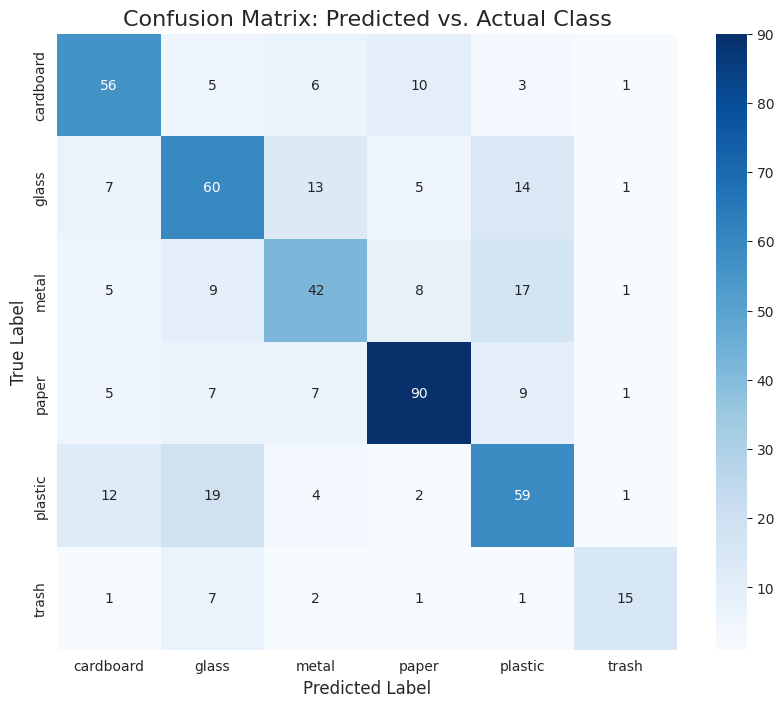


Generating 8.3: One-vs-Rest (OvR) ROC Curves...


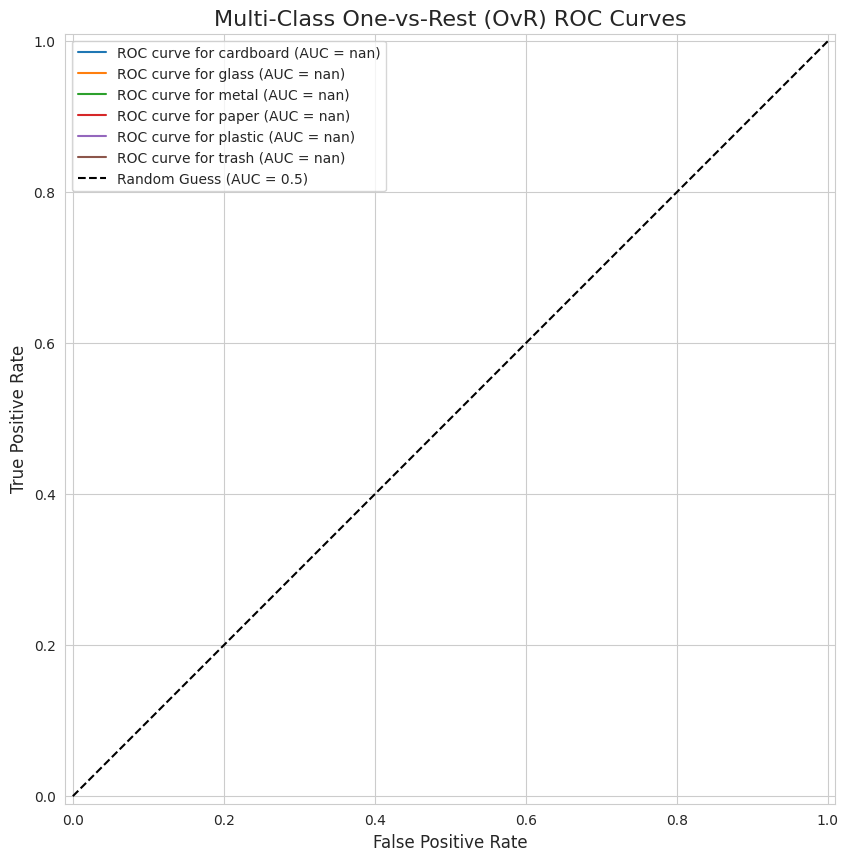

In [17]:

# -----------------------------------------------------------------------
# Section 8: Deep Model Evaluation (from Week 7)
# -----------------------------------------------------------------------
print("\n--- Section 8: Deep Evaluation of Best Model (Week 7) ---")
print("Using Random Forest (our best model) for detailed evaluation.")

# --- 8.1: Classification Report (Precision, Recall, F1) ---
print("\n--- 8.1: Classification Report ---")
# This report is the core of Assignment 7
print(classification_report(y_test, y_pred_rf, target_names=CLASSES))

# --- 8.2: Confusion Matrix ---
print("Generating 8.2: Confusion Matrix plot...")
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASSES,
    yticklabels=CLASSES
)
plt.title('Confusion Matrix: Predicted vs. Actual Class', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# --- 8.3: ROC Curve (One-vs-Rest) ---
print("\nGenerating 8.3: One-vs-Rest (OvR) ROC Curves...")
# We need the prediction probabilities for ROC curves
y_proba_rf = model_rf.predict_proba(X_test)
# We must binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y, classes=list(range(len(CLASSES))))[y_test]

plt.figure(figsize=(12, 10))
ax = plt.gca()
for i, class_name in enumerate(CLASSES):
    RocCurveDisplay.from_predictions(
        y_test_binarized[:, i],
        y_proba_rf[:, i],
        name=f"ROC curve for {class_name}",
        ax=ax
    )
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
plt.title('Multi-Class One-vs-Rest (OvR) ROC Curves', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



--- Section 9: Unsupervised Learning (Week 8) ---
Running K-Means clustering (n_clusters=6)...
K-Means clustering complete.
Running PCA (n_components=2)...
PCA complete. Data reduced to 2 dimensions.
Generating 9.4: PCA Clustering Visualization...


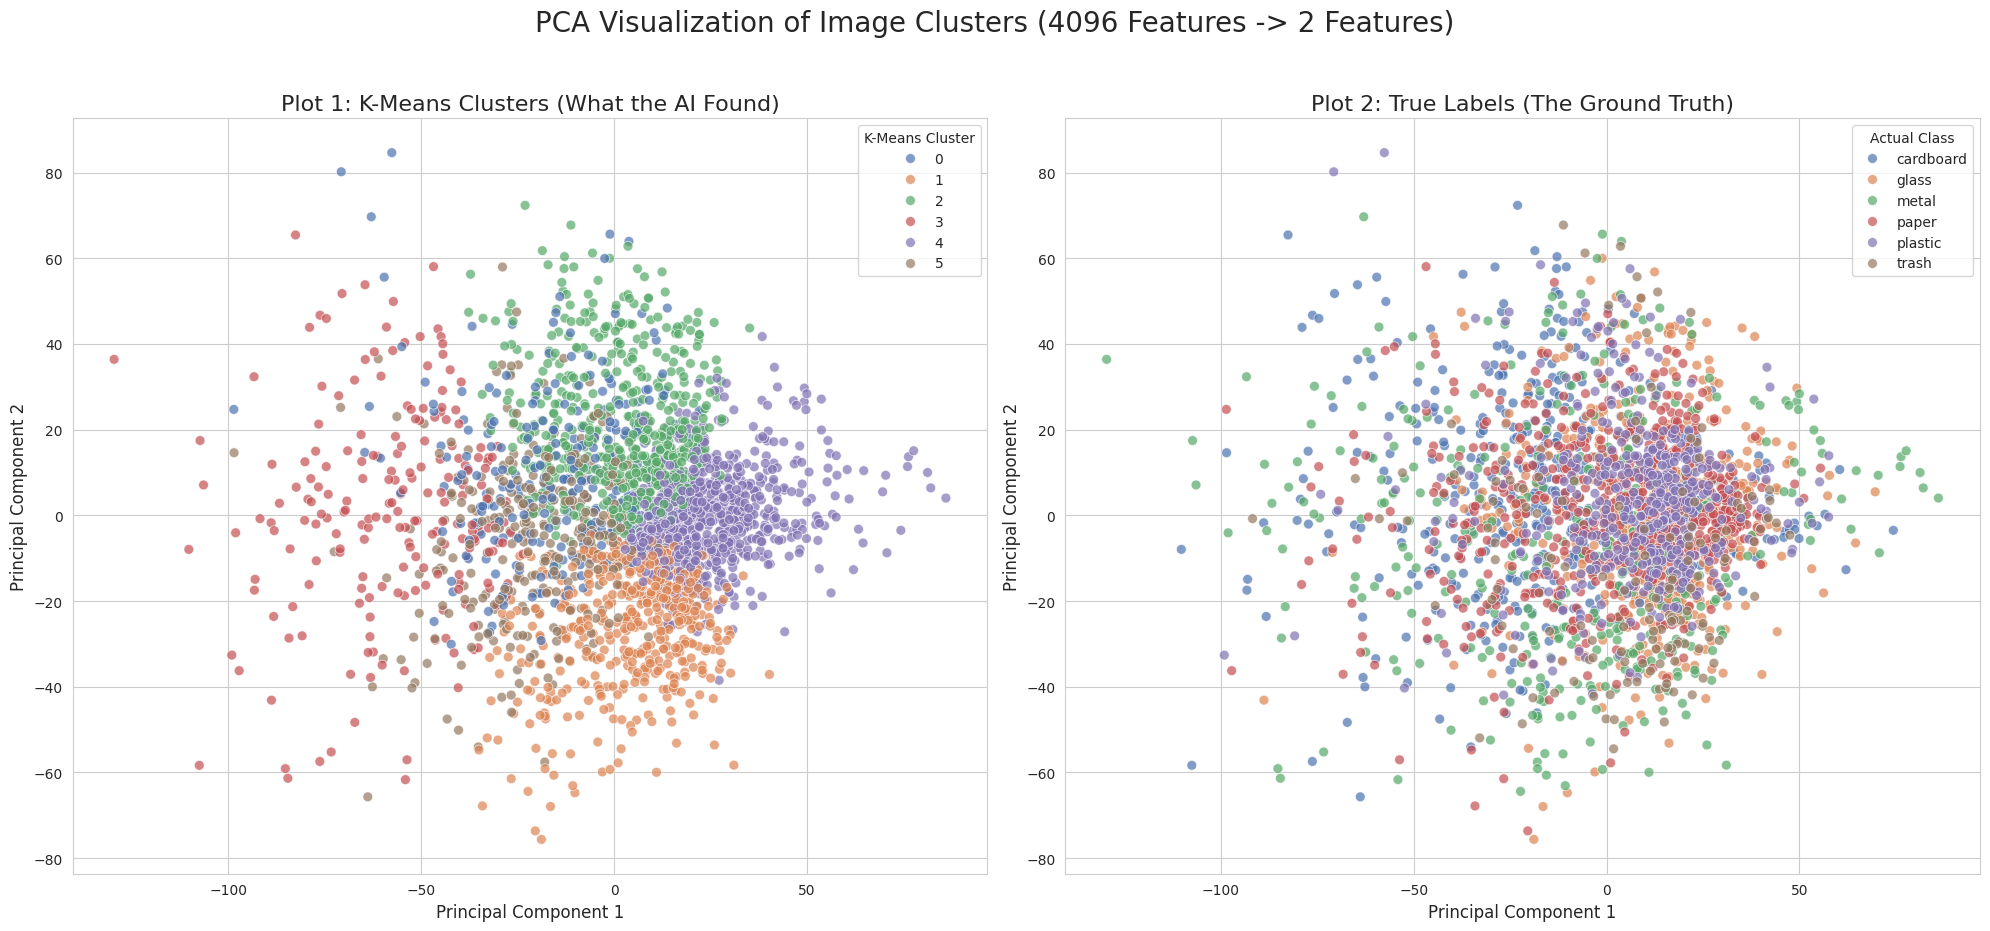


--- Mid-Term Project Notebook (W1-8) Complete ---


In [18]:

# -----------------------------------------------------------------------
# Section 9: Unsupervised Learning (from Week 8)
# -----------------------------------------------------------------------
print("\n--- Section 9: Unsupervised Learning (Week 8) ---")

# --- 9.1: K-Means Clustering ---
# We use the same X_scaled (flattened) data
print("Running K-Means clustering (n_clusters=6)...")
model_kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_labels = model_kmeans.fit_predict(X_scaled)
print("K-Means clustering complete.")

# --- 9.2: PCA (Dimensionality Reduction) ---
print("Running PCA (n_components=2)...")
model_pca = PCA(n_components=2, random_state=42)
X_pca = model_pca.fit_transform(X_scaled)
print("PCA complete. Data reduced to 2 dimensions.")

# --- 9.3: Combine results for plotting ---
df_pca = pd.DataFrame(data=X_pca, columns=['PCA 1', 'PCA 2'])
df_pca['kmeans_cluster'] = kmeans_labels
df_pca['true_label'] = y # Note: using all of y, not just y_test
df_pca['true_class_name'] = df_pca['true_label'].map(lambda i: CLASSES[i])

# --- 9.4: Visualization ---
print("Generating 9.4: PCA Clustering Visualization...")
plt.figure(figsize=(20, 9))
sns.set_style("whitegrid")

# Plot 1: Clusters found by K-Means
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_pca,
    x='PCA 1',
    y='PCA 2',
    hue='kmeans_cluster',
    palette='deep',
    s=50,
    alpha=0.7
)
plt.title('Plot 1: K-Means Clusters (What the AI Found)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='K-Means Cluster')

# Plot 2: True, Actual Labels
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_pca,
    x='PCA 1',
    y='PCA 2',
    hue='true_class_name', # Color by the *real* class names
    palette='deep',
    s=50,
    alpha=0.7
)
plt.title('Plot 2: True Labels (The Ground Truth)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Actual Class')

plt.suptitle('PCA Visualization of Image Clusters (4096 Features -> 2 Features)', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

print("\n--- Mid-Term Project Notebook (W1-8) Complete ---")

